<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> Ecuaciones Diferenciales Parciales: Elípticas </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.1</h2>
</center>

# Tabla de Contenidos
* [Introducción](#intro)
* [Marco Teórico](#teo)
* [FEM en 1D](#1d)
    * [Condiciones de Borde de Dirichlet](#dir)
    * [Condiciones de Borde de Neumann](#neu)
* [FEM en 2D](#2d)
* [Acknowledgements](#acknowledgements)

In [1]:
%matplotlib inline
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import dia_matrix
from matplotlib import pyplot as plt
from numpy.linalg import solve, norm, lstsq
from pdb import set_trace as st

In [2]:
def Error(x, u, u_h):
  h = x[1]-x[0]
  e = norm(u(x)-u_h) * np.sqrt(h)
  return e

def SolutionPlot(x, u, u_h):
  plt.figure(figsize=(10,6))
  xx = np.linspace(x[0], x[-1], 10*len(x))
  plt.plot(xx, u(xx), '-', label="u(x)")
  plt.plot(x, u_h, 'o--', label="u_h(x)")
  plt.xlabel('x')
  plt.ylabel('u(x)')
  plt.legend(loc=0, numpoints=1)
  plt.show()  

def ErrorPlot(h_list, error_list):
  plt.figure(figsize=(10,6))
  # First plot
  plt.subplot(2,1,1)
  plt.plot(h_list, error_list, 'gs--', label='$||u-u_h||_{L^2}$', lw=1.5, mew=1.5)
  plt.xlabel('h')
  plt.ylabel('$L^2$ norm error')
  plt.legend(loc=0, numpoints=1)
  #plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%1.2E'))
  # log Error h plot
  plt.subplot(2,1,2)
  plt.semilogy(h_list, error_list, 'go--',label='$||u-u_h||_{L^2}$', lw=1.5, mew=1.5)
  #plt.plot(log_h, m*log_h+c, 'k-',label='%1.2f log(h) + %1.2f' %(m,c))
  plt.xlabel('h')
  plt.ylabel('$L^2$ norm log error')
  plt.legend(loc=0, numpoints=1)
  # Least squares fit of the loglog
  plt.show()
  return

<div id='intro' />
# Introducción

Al igual que en el anterior, en el siguiente notebook se estudiará la resolución numérica de **ecuaciones diferenciales parciales elípticas**. Sin ser necesaria la repetición de la introducción a las PDE, cabe destacar que en esta ocasión variaremos el método utilizado para resolverlas, siendo éste el método de **elementos finitos** (FEM), el cual es un método muy popular en la ingeniería.  

A continuación veremos una breve explicación del método junto con aplicaciones prácticas al caso 1D y 2D.

<div id='teo' />
# Marco Teórico

El método de elementos finitos consiste, en palabras simples, en la discretización del dominio (cuerpo) sobre el cual queremos resolver la ecuación diferencial en cuestión. Esto lo logramos mediante la definición de numerosos subdominios no intersectantes entre sí llamados elementos finitos. 

Al lograr expresar la ecuación diferencial que deseamos resolver en su forma débil o variacional (en forma de integral), se establecen condiciones de vínculo entre los elementos finitos de nuestro dominio, generándose un sistema de ecuaciones que debe ser resuelto numéricamente para obtener nuestra solución aproximada.

A modo de ejemplo, consideremos la siguiente ecuación en 1D:

\begin{align*}
-\frac{d^2u(x)}{dx^2} + u(x) = f(x) \ , \ x \in [0,1] \\
\end{align*}

\begin{align*}
u(0) = u(1) = 0
\end{align*}

Multiplicando por $v(x)$ (con $v(0)=v(1)=0$) e integrando obtenemos:

\begin{align*}
- \int_0^1 \frac{d^2u(x)}{dx^2}v(x)dx + \int_0^1 u(x)v(x)dx = \int_0^1  f(x)v(x)dx \\
\end{align*}

Si integramos por partes el primer término obtenemos: 

\begin{align*}
-\int_0^1 \frac{d^2u(x)}{dx^2}v(x)dx = -\left. \frac{du(x)}{dx}v(x)\right|^1_0 + \int_0^1 \frac{du(x)}{dx}v'(x)dx
\end{align*}

Debido a nuestra definición de $v(x)$ podemos eliminar el término en donde esta función es evaluada en los bordes, por lo que nuestra ecuación en su forma variacional sería:

\begin{align*}
\int_0^1 \frac{du(x)}{dx}\frac{dv(x)}{dx}dx + \int_0^1 u(x)v(x)dx = \int_0^1  f(x)v(x)dx 
\end{align*}

Lo que sigue es expresar nuestra solución $u(x)$ como una combinación lineal de una base finita del espacio $L^2[0,1]$, digamos $\langle \phi_0(x),\phi_1(x),\dots,\phi_{n+1}(x)\rangle$. En otras palabras, $u(x) = \sum_{i=0}^{n+1}c_i\phi_i(x)$, y adicionalmente, redefinimos $v(x)=\phi_k(x)$, para $k=1:n$. Por lo tanto, nuestra ecuación se transforma en:

\begin{align*}
\sum_{i=0}^{n+1}c_i \left( \int_0^1 \phi_i'(x)\phi_k'(x)dx + \int_0^1 \phi_i(x)\phi_k(x)dx \right) = \int_0^1  f(x)\phi_k(x)dx 
\end{align*}

Luego, definiendo $\phi_i(x)$ como:

\begin{equation*}
\phi_i(x) = \left\{ 
\begin{array}{ll} 
\dfrac{x-x_{i-1}}{x_i-x_{i-1}} \; & \text{si } x_{i-1} < x \leq x_i \\
\dfrac{x_{i+1}-x}{x_{i+1}-x_i} \; & \text{si } x_i < x \leq x_{i+1} \\
0 \; & \text{en otros casos} 
\end{array} \right. 
\end{equation*}

Obtenemos los siguientes valores para las integrales:

\begin{equation*} 
\begin{array}{rl} 
\int_0^1 \phi_i(x)\phi_{i+1}(x)dx =& \dfrac{\Delta x}{6} \\
\int_0^1 (\phi_i(x))^2dx =& \dfrac{2 \Delta x}{3} \\
\int_0^1 \phi_i'(x)\phi_{i+1}'(x)dx =& - \dfrac{1}{\Delta x} \\
\int_0^1 (\phi_i'(x))^2dx =& \dfrac{2}{\Delta x} 
\end{array}
\end{equation*}

Por lo que finalmente, al discretizar el dominio $[0,1]$ en $n+2$ puntos $x_0,x_1,x_2,\dots,x_n,x_{n+1}$, todo se resume en resolver el siguiente sistema de ecuaciones:

\begin{equation*}
\left[ \begin{array}{ccccccc}
\gamma_{i,i} & \gamma_{i,i+1} & 0 & \cdots & 0 & 0 & 0 \\
\gamma_{i,i+1} & \gamma_{i,i} & \gamma_{i,i+1} & \cdots & 0 & 0 & 0 \\
0 & \gamma_{i,i+1} & \gamma_{i,i} & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & \gamma_{i,i} & \gamma_{i,i+1} & 0 \\
0 & 0 & 0 & \cdots & \gamma_{i,i+1} & \gamma_{i,i} & \gamma_{i,i+1}\\
0 & 0 & 0 & \cdots & 0 & \gamma_{i,i+1} & \gamma_{i,i}
\end{array} \right] \left[ \begin{array}{c}
c_1 \\ c_2 \\ c_3 \\ \vdots \\ c_{n-2} \\ c_{n-1} \\ c_n
\end{array} \right] = \left[ \begin{array}{c}
\Delta x \cdot f(x_1) \\ \Delta x \cdot f(x_2) \\ \Delta x \cdot f(x_3) \\ \vdots \\ \Delta x \cdot f(x_{n-2}) \\ \Delta x \cdot f(x_{n-1}) \\ \Delta x \cdot f(x_n)
\end{array} \right]
\end{equation*}

Donde $\gamma_{i,i} = \dfrac{2 \Delta x}{3} + \dfrac{2}{\Delta x}$ y $\gamma_{i,i+1} = \dfrac{\Delta x}{6} - \dfrac{1}{\Delta x}$.

Es importante notar que dada la definición de $\phi_i(x)$, se obtiene que $u(x_i) = c_i$, por lo que $c_0 = u(x_0) = u(0) = 0$ y $c_{m+1} = u(x_{m+1}) = u(1) = 0$.

<div id='1d' />
# FEM en 1D #

## El problema ##

Deseamos solucionar el mismo problema visto en la sección anterior:

\begin{align*}
-\frac{d^2u(x)}{dx^2} + u(x) = f(x) \ , \ x \in [0,1] \\
\end{align*}

\begin{align*}
u(0) = u(1) = 0
\end{align*}

Cuya formulación variacional según vimos es:

\begin{align*}
\int_0^1 \frac{du(x)}{dx} \frac{dv(x)}{dx} dx +  \int_0^1 u(x) v(x) dx =  \int_0^1 f(x) v(x) dx 
\end{align*}

## Solución numérica ##


In [3]:
f1 = lambda x: 0*x
P1 = {"f":f1, "a":0, "b":1}
u1 = lambda x: 0*x
P1_sol = {"u": u1}

f2 = lambda x: x**2 - x - 2 
P2 = {"f":f2, "a":0, "b":1}
u2 = lambda x: x*(x-1)
P2_sol = {"u": u2}

f3 = lambda x: np.exp(-(x-.5)**2)
P3 = {"f":f3, "a":0, "b":1}
P3_sol = {"u": None}

f4 = lambda x: np.where(x<=.5, 0, 1)
P4 = {"f":f4, "a":0, "b":1}
P4_sol = {"u": None}

def FEM(P, u0, u1, N=5):
    # Parameters
    x = np.linspace(P["a"], P["b"], N+2)
    dx = x[1]-x[0]
    # Matrix K
    diag = (2./dx + 2.*dx/3.)*np.ones(N)
    udiag = (-1./dx + dx/6.)*np.ones(N)
    ldiag = udiag
    K = dia_matrix(([ldiag, diag, udiag], [-1, 0,+1]), shape=(N, N))
    # Right hand side
    b = dx*P["f"](x[1:-1])
    # Return the solution
    c = [u0] + list(spsolve(K, b)) + [u1]
    return x, c

/Users/claudio/anaconda/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:96: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


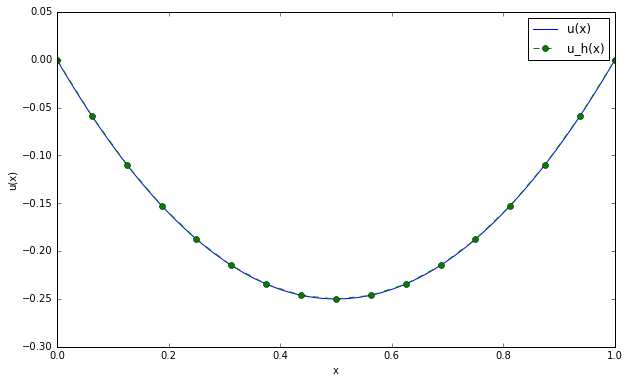

In [4]:
P, P_sol = P2, P2_sol
x, c = FEM(P, 0, 0, N=15)
SolutionPlot(x, P_sol['u'], c)

<div id='dir' />
## Condiciones de Borde de Dirichlet ##

Si bien, el problema que ya resolvimos también tenía este tipo de condiciones de borde, volveremos a echarles un vistazo.

En esta ocasión resolveremos el siguiente problema:

\begin{align*}
-\frac{d^2u(x)}{dx^2} = f(x) \ , \ x \in [0,1] \\
\end{align*}

\begin{align*}
u(0) = u(1) = 0
\end{align*}

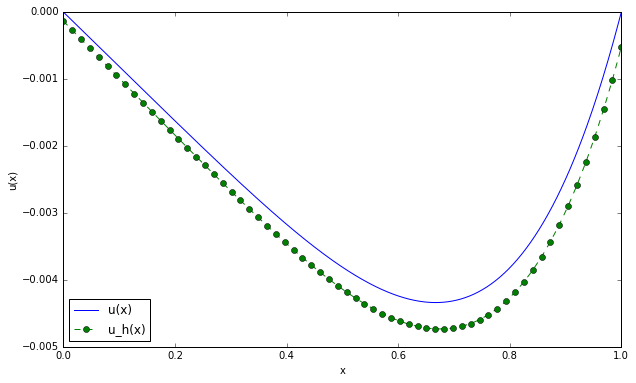

/Users/claudio/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


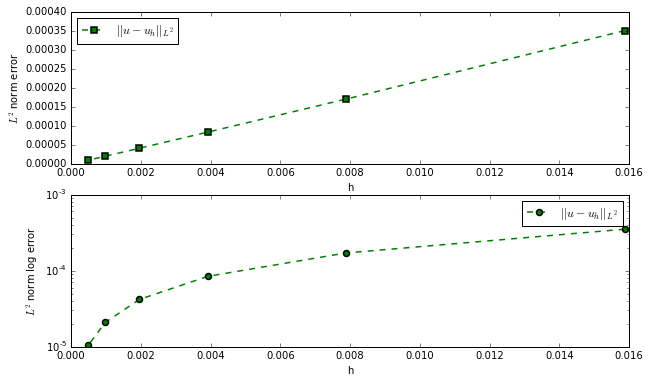

In [5]:
def DirichletSolver(f, N):
  x = np.linspace(0., 1., N)
  h = x[1]-x[0]
  K = (1./h)*(  np.diag(-1*np.ones(N-1),-1) 
               +np.diag( 2*np.ones(N), 0) 
               +np.diag(-1*np.ones(N-1),+1)
               )
  b = h*f(x)
  u = solve(K, b)
  return x, u

f1 = lambda x : np.e**x
u1 = lambda x : -np.e**x + (np.e - 1.)*x + 1.

f2 = lambda x : np.sin(x) - x 
u2 = lambda x : np.sin(x) - x*np.sin(1.) +  (x**3 - x )/6.

# Example
f, u = f2, u2
N = 64
x, u_h = DirichletSolver(f, N)
SolutionPlot(x, u, u_h)

# Convergence
f, u = f2, u2

N_list = 64.*2**np.arange(6)
h_list = []
error_list = []
for N in N_list:
  x, u_h = DirichletSolver(f, N)
  h = x[1]-x[0]
  h_list.append(h)
  error_list.append(Error(x, u, u_h) )

ErrorPlot(h_list, error_list)

<div id='neu' />
## Condiciones de Borde de Neumann ##

Ahora resolveremos la misma ecuación, pero con una condición de borde de Neumann cuando $x=1$. Esta vez tenemos:

\begin{align*}
-\frac{d^2u(x)}{dx^2} = f(x) \ , \ x \in [0,1] \\
\end{align*}

\begin{align*}
u(0) = u'(1) = 1
\end{align*}

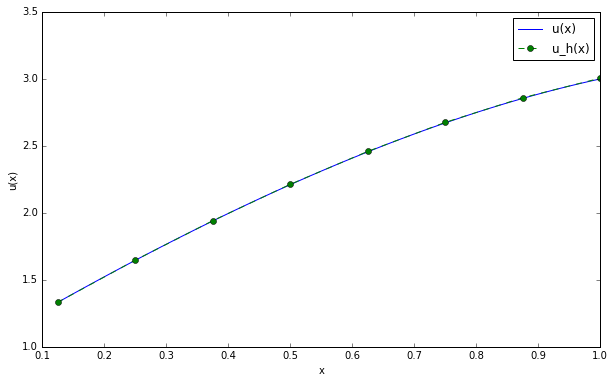

/Users/claudio/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


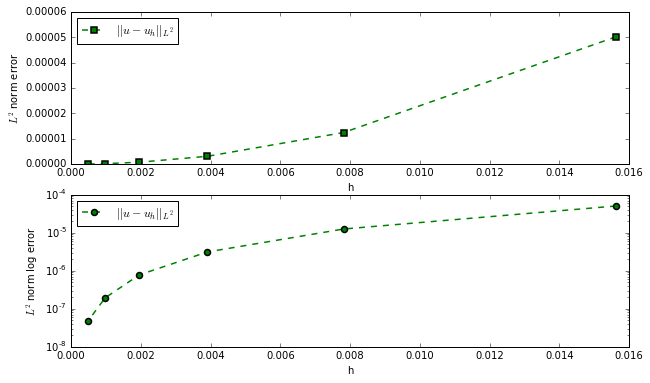

In [6]:
def NeumannSolver(f, N):
  x = np.arange(1.,N+1.)/N
  h = 1./N
  K = (1./h)*( np.diag(-1*np.ones(N-1),-1) 
              +np.diag( 2*np.ones(N), 0) 
              +np.diag(-1*np.ones(N-1),+1)
              )
  K[-1,-2:] = [-1/h, 1/h]
  b = h*f(x)
  b[-1] = h/2.*f(1.0) + 1.0
  u = solve(K, b) + 1
  return x, u

f1 = lambda x : np.e**x
u1 = lambda x : -np.e**x + (np.e + 1.)*x + 2.

f2 = lambda x : np.sin(x) - x 
u2 = lambda x : np.sin(x) + x**3/6. + x*(1./2. - np.cos(1.) ) + 1.

# Example
f, u = f1, u1
N = 8
x, u_h = NeumannSolver(f, N)
SolutionPlot(x, u, u_h)

# Convergence
f, u = f1, u1

N_list = 64.*2**np.arange(6)
h_list = []
error_list = []
for N in N_list:
  x, u_h = NeumannSolver(f, N)
  h = x[1]-x[0]
  h_list.append(h)
  error_list.append(Error(x, u, u_h) )

ErrorPlot(h_list, error_list)

<div id='2d' />
# FEM en 2D #

Consideremos la ecuación:

\begin{align*}
-\Delta u(x,y) + u(x,y) = f(x,y) \ , \ (x,y) \in \Omega \\
\end{align*}

\begin{align*}
u(\Omega) = 0
\end{align*}

Repitiendo el mismo procedimiento visto en el [Marco Teórico](#teo), llegamos a la formulación variacional:

\begin{align*}
\int_{\Omega} \nabla u(x,y) \cdot \nabla v(x,y) dA + \int_{\Omega} u(x,y)v(x,y)dA = \int_{\Omega}  f(x,y)v(x,y)dA
\end{align*}

Con $u(x,y) = \sum_{i=0}^{n+1} c_i \phi_i(x,y)$ y $v(x,y) = \phi_k(x,y)$ para $k=1:n$.



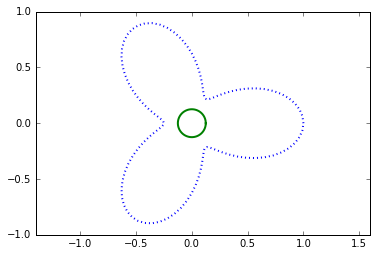

In [7]:
N = 100.
theta = np.arange(0.,N+1)*2.*np.pi/N
lw = 2
r_o = 5./8. + 3./8.*np.cos(3*theta)
r_i = 1./8. + 0*theta

x_o, y_o = r_o*np.cos(theta), r_o*np.sin(theta)
plt.plot(x_o, y_o, ':', label='$\Gamma_o$', lw=lw)

x_i, y_i = r_i*np.cos(theta), r_i*np.sin(theta)
plt.plot(x_i, y_i, '-', label='$\Gamma_i$',lw=lw)
plt.axis('equal')
plt.show()

<div id='acknowledgements' />
# Acknowledgements
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín Villanueva. DI UTFSM. Abril 2016._

***
### DISCLAIMER ###

El presente ipython notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres y Sebastian Flores, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2016] (Álvaro) Se agregó tabla de contenidos, contexto y marco teórico. Se unieron los notebooks de 1D y 2D. Adicionalmente se adjuntaron los códigos de condiciones de Dirichlet y Neumann.
***